# Buy and Hold Strategy Experiment

## Import Libraries

In [137]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## Grab Historical Data

In [138]:
# Specify the time period
start_date = '2005-01-01'
end_date = '2025-01-01'

startfile = "checkpoint_b"

In [139]:
# Use yfinance to retrieve data
symbols = ['SPY', 'TLT', 'VTI']

historical_data = {}

for symbol in symbols:
    ticker = yf.Ticker(symbol)
    data = ticker.history(start='2005-01-01', end='2025-01-01')
    historical_data[symbol] = data
    # Save data to CSV
    data.to_csv(f"{startfile}_{symbol.lower()}.csv")

In [140]:
# Combine the data into one df
combined_data = pd.concat(historical_data.values(), keys=historical_data.keys(), axis=1)

print(combined_data.head())

                                 SPY                                   \
                                Open       High        Low      Close   
Date                                                                    
2005-01-03 00:00:00-05:00  82.704370  82.840445  81.574978  81.847122   
2005-01-04 00:00:00-05:00  81.955983  82.010413  80.581661  80.847000   
2005-01-05 00:00:00-05:00  80.785744  81.132728  80.282280  80.289085   
2005-01-06 00:00:00-05:00  80.581667  81.064721  80.459202  80.697327   
2005-01-07 00:00:00-05:00  80.942270  81.119164  80.370766  80.581680   

                                                                          \
                             Volume Dividends Stock Splits Capital Gains   
Date                                                                       
2005-01-03 00:00:00-05:00  55748000       0.0          0.0           0.0   
2005-01-04 00:00:00-05:00  69167600       0.0          0.0           0.0   
2005-01-05 00:00:00-05:00  65667300

## Calculate Log Daily Returns for Analysis

In [141]:
# Calculate log daily returns
close_df = combined_data.xs('Close', level=1, axis=1)

log_daily_returns = np.log(close_df / close_df.shift(1))

print(log_daily_returns.head())

                                SPY       TLT       VTI
Date                                                   
2005-01-03 00:00:00-05:00       NaN       NaN       NaN
2005-01-04 00:00:00-05:00 -0.012295 -0.010535 -0.013400
2005-01-05 00:00:00-05:00 -0.006925  0.005338 -0.006942
2005-01-06 00:00:00-05:00  0.005072  0.000679  0.004778
2005-01-07 00:00:00-05:00 -0.001434  0.002262 -0.003212


In [142]:
# Drop missing values
log_daily_returns = log_daily_returns.dropna()
print(log_daily_returns.head())

                                SPY       TLT       VTI
Date                                                   
2005-01-04 00:00:00-05:00 -0.012295 -0.010535 -0.013400
2005-01-05 00:00:00-05:00 -0.006925  0.005338 -0.006942
2005-01-06 00:00:00-05:00  0.005072  0.000679  0.004778
2005-01-07 00:00:00-05:00 -0.001434  0.002262 -0.003212
2005-01-10 00:00:00-05:00  0.004717  0.001579  0.003992


## Finding Initial Conditions for Chosen Assets

In [143]:
# Covariance Matrix
cov_matrix = log_daily_returns.cov()*252

print(cov_matrix)

          SPY       TLT       VTI
SPY  0.036317 -0.009123  0.036477
TLT -0.009123  0.021891 -0.009166
VTI  0.036477 -0.009166  0.037152


## Helper Functions

In [144]:
# Volatility function
def std_deviation(weights, cov_matrix):
  variance = weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

In [145]:
# Expected returns function
def expected_return(weights, log_daily_returns):
  return np.sum(log_daily_returns.mean() * weights)

In [146]:
# Sharpe Ratio function
def sharpe_ratio(weights, log_daily_returns, cov_matrix, risk_free_rate):
  return (expected_return(weights, log_daily_returns) - risk_free_rate) / std_deviation(weights, cov_matrix)

In [147]:
# Use risk-free rate from optimization example
risk_free_rate = 1.01

## Optimization First Using Quadratic Programming

In [148]:
# Negative Sharpe Ratio function
def neg_sharpe_ratio(weights, log_daily_returns, cov_matrix, risk_free_rate):
  return -sharpe_ratio(weights, log_daily_returns, cov_matrix, risk_free_rate)

In [149]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} # All weights must add to 1
bounds = [(0, 0.5) for _ in range(len(symbols))] # No short selling and no more than 50% allocation for each asset
initial_weights = [1/len(symbols)] * len(symbols) # Start with balanced portfolio
print(initial_weights)

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [150]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_daily_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimized_results.x

In [151]:
# Results from QP
print('Optimal ETF Portfolio Weights:')
for symbol, weight in zip(symbols, optimal_weights):
  print(f'{symbol}: {weight:.4f}')

print()

optimal_return = expected_return(optimal_weights, log_daily_returns)
optimal_volatility = std_deviation(optimal_weights, cov_matrix)
optimal_sharpe = sharpe_ratio(optimal_weights, log_daily_returns, cov_matrix, risk_free_rate)

print(f'Expected Return: {optimal_return:.4f}')
print(f'Volatility (Standard Deviation): {optimal_volatility:.4f}')
print(f'Sharpe Ratio: {optimal_sharpe:.4f}')

Optimal ETF Portfolio Weights:
SPY: 0.5000
TLT: 0.0000
VTI: 0.5000

Expected Return: 0.0004
Volatility (Standard Deviation): 0.1913
Sharpe Ratio: -5.2769


In [152]:
# Calculate the annualized expected log return
annualized_expected_log_return = optimal_return * 252

# Calculate the annualized expected simple return
annualized_expected_simple_return = np.exp(annualized_expected_log_return) - 1

print(f"Optimal Portfolio - Annualized Expected Log Return: {annualized_expected_log_return:.4f}")
print(f"Optimal Portfolio - Annualized Expected Simple Return: {annualized_expected_simple_return:.4f}")

Optimal Portfolio - Annualized Expected Log Return: 0.0983
Optimal Portfolio - Annualized Expected Simple Return: 0.1033


## Monte Carlo Simulation to Add Randomness

In [153]:
# Generate random sets of weights
num_portfolios = 700
num_assets = len(symbols)
shortsOK = False  # Set to True for short selling allowed, False otherwise

if shortsOK == True:
    weights = np.random.uniform(-1, 1, size=(num_portfolios, num_assets))
else:
    weights = np.random.uniform(0, 1, size=(num_portfolios, num_assets))
    weights = weights / np.sum(weights, axis=1)[:, np.newaxis] # Normalize weights to sum to 1

print("Generated Weights (first 5 rows):")
print(weights[:5])

Generated Weights (first 5 rows):
[[0.21319848 0.33706106 0.44974046]
 [0.042247   0.50424072 0.45351227]
 [0.36805262 0.37907494 0.25287244]
 [0.05398829 0.4519045  0.4941072 ]
 [0.51821359 0.072156   0.40963042]]


In [154]:
# Calculate portfolio returns and volatility
portfolio_returns = []
portfolio_volatility = []
all_weights = []
position_status = [] # To store "Shorts Allowed" or "No Shorts"

num_trading_days = 252 # Number of trading days in a year

# Calculate mean daily returns for each asset
mean_daily_returns = log_daily_returns.mean()

for single_weights in weights:
    all_weights.append(single_weights)
    # Calculate portfolio return
    returns = np.dot(single_weights, mean_daily_returns) * num_trading_days
    portfolio_returns.append(returns)

    covariance_matrix_np = np.array(cov_matrix)
    # Calculate portfolio volatility
    volatility = std_deviation(single_weights, cov_matrix) * np.sqrt(num_trading_days)
    portfolio_volatility.append(volatility)

    position_status.append("Shorts Allowed" if shortsOK else "No Shorts")


# Create a DataFrame for the portfolio results
mc_portfolio_results_df = pd.DataFrame({
    'Return': portfolio_returns,
    'Volatility': portfolio_volatility,
    'Weights': all_weights,
    'Position': position_status
})


print("MC Portfolio Results:")
mc_portfolio_results_df.head().T

MC Portfolio Results:


,0,1,2,3,4
Return,0.075637,0.064405,0.072755,0.067934,0.093425
Volatility,1.915315,1.594477,1.804933,1.669029,2.766131
Weights,"[0.21319847839100153, 0.33706106229067423, 0.4...","[0.04224700463634449, 0.504240722670449, 0.453...","[0.36805261808488327, 0.37907494257218977, 0.2...","[0.05398829054919137, 0.45190450447662095, 0.4...","[0.518213586475544, 0.07215599653564818, 0.409..."
Position,No Shorts,No Shorts,No Shorts,No Shorts,No Shorts


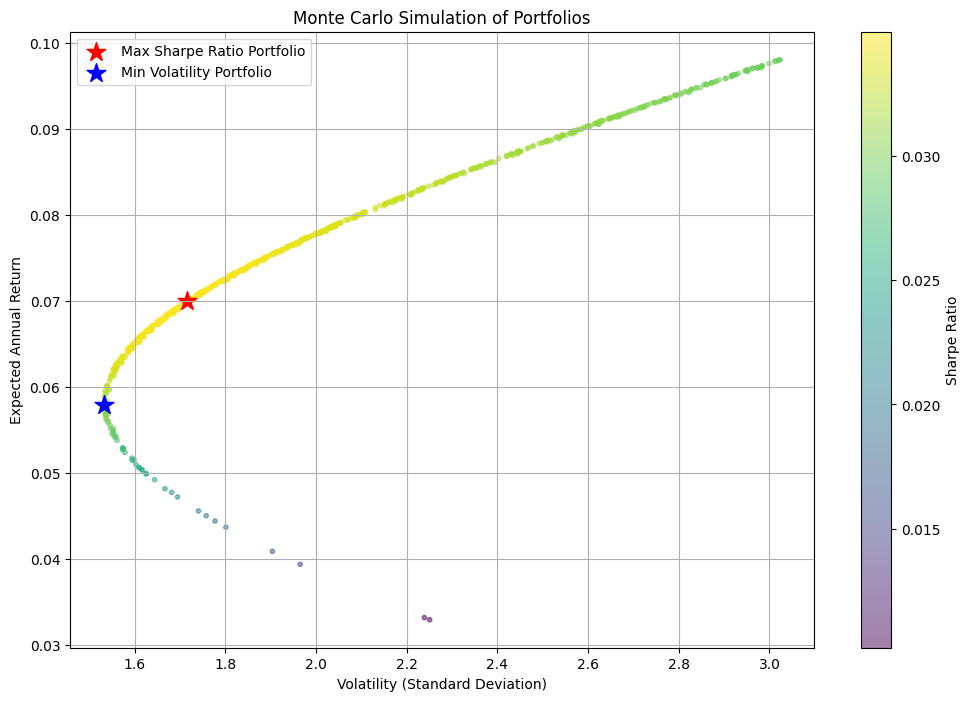


Portfolio from mc_portfolio_results_df with Maximum Sharpe Ratio:
Return                                                   0.070053
Volatility                                               1.715958
Weights         [0.5475959746569641, 0.41831041259044366, 0.03...
Position                                                No Shorts
Sharpe Ratio                                             0.034997
Name: 65, dtype: object

Portfolio from mc_portfolio_results_df with Minimum Volatility:
Return                                                   0.057973
Volatility                                               1.532029
Weights         [0.36839729041471125, 0.5980888082578771, 0.03...
Position                                                No Shorts
Sharpe Ratio                                             0.031314
Name: 35, dtype: object


In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Use (risk_free_rate - 1) for the excess return
mc_portfolio_results_df['Sharpe Ratio'] = (mc_portfolio_results_df['Return'] - (risk_free_rate - 1)) / mc_portfolio_results_df['Volatility']

# Find the portfolio with the maximum Sharpe Ratio
max_sharpe_portfolio_mc = mc_portfolio_results_df.loc[mc_portfolio_results_df['Sharpe Ratio'].idxmax()]

# Find the portfolio with the minimum volatility
min_volatility_portfolio_mc = mc_portfolio_results_df.loc[mc_portfolio_results_df['Volatility'].idxmin()]

# Plot the simulated portfolios
plt.figure(figsize=(12, 8))
plt.scatter(mc_portfolio_results_df['Volatility'], mc_portfolio_results_df['Return'], c=mc_portfolio_results_df['Sharpe Ratio'], cmap='viridis', marker='o', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.title('Monte Carlo Simulation of Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Annual Return')
plt.grid(True)

# Plot the portfolio with the maximum Sharpe Ratio
plt.scatter(max_sharpe_portfolio_mc['Volatility'], max_sharpe_portfolio_mc['Return'], color='red', marker='*', s=200, label='Max Sharpe Ratio Portfolio')

# Plot the portfolio with the minimum volatility
plt.scatter(min_volatility_portfolio_mc['Volatility'], min_volatility_portfolio_mc['Return'], color='blue', marker='*', s=200, label='Min Volatility Portfolio')

# Add legend
plt.legend()

# Show the plot
plt.show()

print("\nPortfolio from mc_portfolio_results_df with Maximum Sharpe Ratio:")
print(max_sharpe_portfolio_mc)

print("\nPortfolio from mc_portfolio_results_df with Minimum Volatility:")
print(min_volatility_portfolio_mc)

In [157]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# Extract SPY data and prepare for backtesting
spy_data = combined_data['SPY'].copy()
if not isinstance(spy_data.index, pd.DatetimeIndex):
    spy_data.index = pd.to_datetime(spy_data.index)
if spy_data.index.tz is not None:
    spy_data.index = spy_data.index.tz_convert(None)
# Drop rows with NaN values in essential columns for RSI (Close is sufficient)
spy_data = spy_data.dropna(subset=['Close', 'Open', 'High', 'Low', 'Volume']) # Ensure all OHLCV needed by Backtest are present


# Define the RSI Trading Strategy
class RsiStrategy(Strategy):
    # Define strategy parameters
    rsi_period = 14 # Common RSI period
    oversold_threshold = 30
    overbought_threshold = 70

    def init(self):
        close_prices = self.data.Close
        delta = pd.Series(close_prices).diff() # Calculate price changes
        gain = delta.where(delta > 0, 0) # Separate gains and losses
        loss = -delta.where(delta < 0, 0)

        # Calculate average gain and average loss using rolling window
        avg_gain = gain.rolling(self.rsi_period).mean()
        avg_loss = loss.rolling(self.rsi_period).mean()

        # Calculate Relative Strength (RS)
        # Avoid division by zero by handling the case where avg_loss is 0
        rs = avg_gain / avg_loss.replace(0, np.nan) # Replace 0 with NaN to avoid division by zero warnings

        # Calculate RSI
        rsi = 100 - (100 / (1 + rs))

        # Register the RSI as an indicator using self.I()
        self.rsi = self.I(pd.Series, rsi)


    def next(self):
        # Implement trading logic based on RSI signals

        # Buy signal: RSI crosses below oversold threshold and then crosses back above
        # Check if RSI is currently above the oversold threshold AND was below it in the previous period
        if crossover(self.rsi, self.oversold_threshold):
             # Close any existing short position and buy
             self.position.close()
             self.buy()

        # Sell signal: RSI crosses above overbought threshold and then crosses back below
        # Check if RSI is currently below the overbought threshold AND was above it in the previous period
        elif crossover(self.overbought_threshold, self.rsi):
             # Close any existing long position and sell (go short)
             self.position.close()
             self.sell()


# Set up and run the backtest for SPY with the RsiStrategy
print("Running Backtest for SPY with RSI Strategy:")
bt_rsi_spy = Backtest(spy_data, RsiStrategy,
                      cash=10000, commission=.005,
                      exclusive_orders=True) # exclusive_orders=True to ensure only one position at a time

# Run the backtest
output_rsi_spy = bt_rsi_spy.run()

# Print the backtest results
print(output_rsi_spy)

# Plot the backtest results
#bt_rsi_spy.plot()

Running Backtest for SPY with RSI Strategy:


Backtest.run:   0%|          | 0/5019 [00:00<?, ?bar/s]

Start                     2005-01-03 05:00:00
End                       2024-12-31 05:00:00
Duration                   7302 days 00:00:00
Exposure Time [%]                    99.12577
Equity Final [$]                    587.40893
Equity Peak [$]                   10218.24709
Commissions [$]                    9279.81247
Return [%]                          -94.12591
Buy & Hold Return [%]               631.24282
Return (Ann.) [%]                   -13.23163
Volatility (Ann.) [%]                15.98862
CAGR [%]                             -9.31931
Sharpe Ratio                         -0.82757
Sortino Ratio                        -1.00804
Calmar Ratio                         -0.14039
Alpha [%]                          -250.68009
Beta                                  0.24801
Max. Drawdown [%]                   -94.25137
Avg. Drawdown [%]                   -24.65563
Max. Drawdown Duration     7217 days 00:00:00
Avg. Drawdown Duration     1814 days 00:00:00
# Trades                          